# Классификация госконтрактов по объектам закупки

## Импорт библиотек

In [1]:
import os
import re
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm, notebook
tqdm.pandas(desc='Progress bar ')

pd.options.display.float_format = '{:0.3f}'.format
pd.options.mode.chained_assignment = None
pd.set_option('display.expand_frame_repr', False)

## Загрузка данных

Ознакомившись с содержим .csv файлов предоставленных заказчиком и сопоставив их с данными с сайта https://zakupki.gov.ru ([объект закупки 1010503136621000017](https://zakupki.gov.ru/epz/contract/contractCard/payment-info-and-target-of-order.html?reestrNumber=1010503136621000017), [объект закупки 1026802173421000064](https://zakupki.gov.ru/epz/contract/contractCard/payment-info-and-target-of-order.html?reestrNumber=1026802173421000064)) были определены наименования полей.

In [2]:
# Заменяем текстовое определение пропусков NaN
na_values = ['<НЕ ОПРЕДЕЛЕНО>', '<НЕ РАСПРЕДЕЛЕНО>', 'N']

# Cписок полей в csv файле
columns = [
    'Реестровый номер контракта',
    'ИКЗ',
    'ИНН поставщика',
    'Полное наименование поставщика',
    'Код региона',
    'Часть реестрового номера',
    'Полное наименование заказчик',
    'Субъект РФ',
    'КБК',
    'Статус контракта',
    'Категория закупок',
    'Уровень бюджета',
    'Дата заключения контракта',
    'Дата начала исполнения',
    'Срок исполнения',
    'Дата последнего обновления',
    'Дата завершения контракта',
    'Дата расторжения контракта',
    'Причина расторжения',
    'Цена фактических затрат',
    'Цена контракта',
    'Сальдо',
    'Особые изменния',
    'Раздел ОКВЭД',
    'Группа по ОКПД',
    'Код ОКПД'
]

# При чтетии .csv можно было бы задать типы через converters, но это увеличивает время прочтения почти на порядок.
# Поэтому используем dtype=defaultdict(lambda: str) чтобы все поля распарсились с типом String
converters = defaultdict(
    str,
    {
        'Реестровый номер контракта': lambda x: pd.to_numeric(x, errors="coerce"),
        'ИНН поставщика': lambda x: pd.to_numeric(x, errors="coerce"),
        'Часть реестрового номера': lambda x: pd.to_numeric(x, errors="coerce"),
        'Цена контракта': lambda x: pd.to_numeric(x, errors="coerce"),
        'Раздел ОКВЭД': str,
        'Код ОКПД': str,
        'Группа по ОКПД': str
    }
)
parse_dates = ['Дата заключения контракта', 'Дата расторжения контракта']

# Выбираем часть полей актуальных для исследования
selected = [0, 2, 4, 9, 10, 11, 12, 16, 17, 18, 20, 23, 24, 25]
selected_columns = {i+1:n for i,n in zip(range(len(columns)), columns) if i in selected}
selected_columns

{1: 'Реестровый номер контракта',
 3: 'ИНН поставщика',
 5: 'Код региона',
 10: 'Статус контракта',
 11: 'Категория закупок',
 12: 'Уровень бюджета',
 13: 'Дата заключения контракта',
 17: 'Дата завершения контракта',
 18: 'Дата расторжения контракта',
 19: 'Причина расторжения',
 21: 'Цена контракта',
 24: 'Раздел ОКВЭД',
 25: 'Группа по ОКПД',
 26: 'Код ОКПД'}

In [3]:
def get_iterator(
    file,
    names,
    na_values,
    converters=None,
    parse_dates=None,
    chunksize=10000,
    skiprows=0,
):
    """
    Функция для вычитывания чанков из архивов .csv
    """
    return pd.read_csv(
        file,
        skiprows=skiprows,
        chunksize=chunksize,
        header=None,
        names=list(names.values()),
        index_col=False,
        on_bad_lines="warn",
        encoding="utf_8",
        escapechar="\\",
        na_values=na_values,
        usecols=list(names.keys()),
        dtype=defaultdict(lambda: str),
        converters=converters,
        parse_dates=parse_dates,
        iterator=True,
    )

По условию задачи необходимо на основе данных с **ftp.zakupki.gov.ru** научиться определять группу, к которой относится контракт с кодом ОКПД-2 41, 42, 43, 71.1.

[Общероссийские классификаторы - коды и расшифровки](https://classifikators.ru/okpd)

Создадим итератор который позволит вычитывать данные небольшими чанками (кусками).

In [4]:
path = "../data/fz.zip"
data = get_iterator(path, selected_columns, na_values)

# Перечень кодов ОКПД которые нам интересны
base = ['41', '42', '43', '71']
# Дополним коды, т.к. в задаче будет таргет "прочее"
base.extend(['45', '46', '47', '49', '50', '51', '52', '55', '56'])

chunks = []
with tqdm(total=3000, position=0, leave=False) as progress_bar:
    for chunk in data:
        # Оставляем только те данные ОКПД которых начинаются с base
        chunk = chunk[
            chunk['Код ОКПД'].map(lambda x: len(set(str(x).startswith(b) for b in base)) == 2)
        ]
        chunks.append(chunk)

        progress_bar.update()

Чтобы ознакомится с данными использовался код:

```python
chunk = data.get_chunk()
chunk.dtypes.astype(str).to_dict()
```

Теперь сформируем финальный датафрейм объединим одтельные чанки.

In [5]:
df = pd.concat(chunks, ignore_index=True)

display(df.head())
print(df.shape)

,Реестровый номер контракта,ИНН поставщика,Код региона,Статус контракта,Категория закупок,Уровень бюджета,Дата заключения контракта,Дата завершения контракта,Дата расторжения контракта,Причина расторжения,Цена контракта,Раздел ОКВЭД,Группа по ОКПД,Код ОКПД
0,1010506281521000039,2334025872,23,Контракт исполнен,Приобретение запасных частей для служебного ав...,федеральный бюджет,2021-12-03,2021-12-20,NaN,NaN,77340.00,NaN,Услуги по оптовой и розничной торговле и услуг...,45.3
1,1010701245721000003,753614108027,NaN,Контракт заключен,организация питания в ИВС,федеральный бюджет,2021-12-07,NaN,NaN,NaN,1895700.00,NaN,Услуги общественного питания,56.1
2,1026600500721000021,0268081331,02,Контракт заключен,Прочие услуги (Оказание услуг по организации п...,федеральный бюджет,2021-12-06,NaN,NaN,NaN,1450000.00,NaN,Услуги общественного питания,56.2
3,1026800281221000031,0268081331,02,Контракт заключен,обеспечение ежедневным трехразовым горячим пит...,федеральный бюджет,2021-12-06,NaN,NaN,NaN,1530000.00,NaN,Услуги общественного питания,56.2
4,1026802173421000064,743201168885,NaN,Контракт исполнен,прочая закупка услуг (услуги по монтажу и пуск...,федеральный бюджет,2021-12-10,2021-12-28,NaN,NaN,248515.44,NaN,Работы строительные специализированные,43.2


(2889484, 14)


## Подготовка данных

Вместо 'Даты завершения контракта' и 'Даты расторжения контракта' определим новое поле которое потребуется для расчета длительности контракта в днях.

In [6]:
df['Дата закрытия контракта'] = np.where(df['Дата завершения контракта'].isnull(), df['Дата расторжения контракта'], df['Дата завершения контракта'])

# Преобразуем в формат datetime
df['Дата заключения контракта'] = pd.to_datetime(df['Дата заключения контракта'], errors="coerce")
df['Дата закрытия контракта'] = pd.to_datetime(df['Дата закрытия контракта'], errors="coerce")

df['Длительность контракта в днях'] = (df['Дата закрытия контракта'] - df['Дата заключения контракта']).dt.days

У части данных "Группа по ОКПД"	равна "Коду ОКПД", это ошибка. Исключим такие данные, так как в соотвествии с заданием нужно научиться определять группу ОКПД по коду ОКПД.

In [7]:
# Строки типа Str не удастся преобразовать в numeriс
df = df[pd.to_numeric(df['Группа по ОКПД'], errors="coerce").isna()]
df.shape

# with pd.option_context('display.max_rows', 1000, 'display.max_columns', 10):
#     display(
#         df[['Код ОКПД', 'Реестровый номер контракта']].groupby(['Код ОКПД']).count()
#     )

(2557042, 16)

Оценим пропуски.

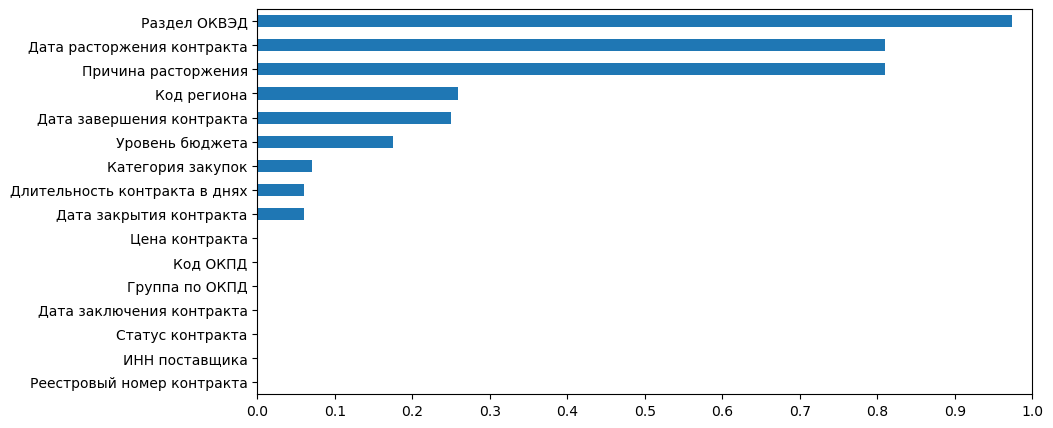

In [8]:
(
    df.isna()
    .mean()
    .sort_values()
    .plot(kind='barh',
          figsize=(10, 3 + len(df.columns) // 6),
          xlim=(0, 1),
          xticks=np.linspace(0, 1, 11))
);

Удалим строки в которых хотя бы одно из полей не определено.

In [9]:
subset = ['Реестровый номер контракта', 'ИНН поставщика', 'Цена контракта', 'Группа по ОКПД', 'Код ОКПД']
df.dropna(how='any', subset=subset, inplace=True)
df.shape

(2556154, 16)

Заменим **Дата расторжения контракта** и **Причина расторжения** на бинарный признак.

In [10]:
df['Причина расторжения'].value_counts()

Причина расторжения
Соглашение сторон                                                                                                                  451128
Односторонний отказ заказчика от исполнения контракта в соответствии с гражданским законодательством                                31313
Судебный акт                                                                                                                         1710
Односторонний отказ поставщика (подрядчика, исполнителя) от исполнения контракта в соответствии с гражданским законодательством      1598
Отмечена как недействительная информация                                                                                               18
Name: count, dtype: int64

Уберем **Раздел ОКВЭД** так как там слишком много пропусков.

In [11]:
df.drop(['Раздел ОКВЭД'], axis=1, inplace=True)

Удалим лишние даты и **Реестровый номер контракта** (уникальный id бесполезен в машинном обучении).

In [12]:
df.drop(['Реестровый номер контракта', 'Дата заключения контракта', 'Дата завершения контракта', 'Дата закрытия контракта', 'Дата расторжения контракта'], axis=1, inplace=True)

Переименуем столбцы чтобы с ними было проще работать в дальнейшем.

In [13]:
# {c:c for c in df.columns}
renames = {
    'ИНН поставщика': 'inn',
    'Код региона': 'region_code',
    'Статус контракта': 'status',
    'Категория закупок': 'category',
    'Уровень бюджета': 'budget_level',
    'Длительность контракта в днях': 'contract_duration',
    'Цена контракта': 'price',
    'Группа по ОКПД': 'okpd_group',
    'Код ОКПД': 'okpd_code',
    'Причина расторжения': 'termination_reason'
}

df = df.rename(columns=renames)[renames.values()]

Изменим тип части полей на int или float.

In [14]:
df['inn'] = pd.to_numeric(df['inn'], errors="coerce")
df['price'] = pd.to_numeric(df['price'], errors="coerce")

df.dtypes

inn                     int64
region_code            object
status                 object
category               object
budget_level           object
contract_duration     float64
price                 float64
okpd_group             object
okpd_code              object
termination_reason     object
dtype: object

После всех преобразований получился такой датафрейм.

In [15]:
display(df.sample(5))
print(df.shape)

,inn,region_code,status,category,budget_level,contract_duration,price,okpd_group,okpd_code,termination_reason
1110308,1831190169,18,Контракт исполнен,Выполнение работ по проведению инженерных изыс...,федеральный бюджет,135.000,387171.000,Услуги в области архитектуры и инженерно-техни...,71.1,NaN
1395494,278109628,02,Контракт исполнен,Выполнение аварийно-восстановительных работ и ...,федеральный бюджет,349.000,660000.000,Работы строительные специализированные,43.2,NaN
370444,121508738797,NaN,Исполнение контракта прекращено,"Поставка бензина АИ-92,АИ-95",федеральный бюджет,70.000,121229.700,"Услуги по оптовой торговле, кроме оптовой торг...",46.7,Соглашение сторон
974771,7743529527,NaN,Контракт исполнен,Поставка бензина марки АИ - 92 для служебного ...,местный бюджет,79.000,98550.000,"Услуги по розничной торговле, кроме розничной ...",47.3,NaN
1638609,344344989175,NaN,Исполнение контракта прекращено,Техническое обслуживание и ремонт автотранспорта,федеральный бюджет,253.000,150000.000,Услуги по оптовой и розничной торговле и услуг...,45.2,Соглашение сторон


(2556154, 10)


Сохраним получивший датафрейм в parquet формате.

In [16]:
df.reset_index(drop=True, inplace=True)
df.to_parquet('../data/fzdata.parquet')